In [1]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import fnmatch 
from tqdm import tqdm 
import fnmatch 
import torch 
import pandas as pd 
from utils import save_dir, analyze_dir, results_dir,train_pool

In [2]:
#def moving_average(x, w):
#    return np.convolve(x, np.ones(w), 'valid') / w

def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

In [3]:
#model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
analyze_identifier= 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'

In [4]:
# load accuracy data first 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

hier_accu=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
    del test 
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [02:07,  8.33it/s]


In [5]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches


In [6]:
# load mftma files 
data_=pickle.load(open(os.path.join(analyze_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_cosine_center_covar_pooled_v3.pkl'), 'rb'))

covar_res=data_['center_covar_results']
#if not os.path.exists(os.path.join(result_dir,analyze_identifier,model_identifier)):
#        os.makedirs(os.path.join(result_dir,analyze_identifier,model_identifier))
temp=[np.asarray([x['seq'] for x in covar_res[y]]) for y in covar_res.keys()]
y=temp[0]
for k in temp:
    y=np.intersect1d(y,k)
    
    

In [7]:
l_num=1
mftma_epochs=[np.asarray([x['epoch'] for x in covar_res[y]]) for y in covar_res.keys()]
mftma_batch=[np.asarray([x['batch'] for x in covar_res[y]]) for y in covar_res.keys()]
layer_data=covar_res['layer_1_Linear']
layer_mftma=[x['center_covar'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_correspondance=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]



In [8]:
x_bar= np.arange(len(batches))/len(batches)
epoch_bar=np.argwhere(np.diff(epochs))/(len(batches))
epoch_bar

array([[0.0990566],
       [0.1990566],
       [0.2990566],
       [0.3990566],
       [0.4990566],
       [0.5990566],
       [0.6990566],
       [0.7990566],
       [0.8990566]])

In [9]:
# recreate the hierarchical classes: 
params = train_pool[model_identifier]()
params.load_dataset()
transfo_mat=params.dataset.transformation_mats


ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "data": shape (128252,), type "|u1">, (uint8)
ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "ir": shape (128252,), type "<u8">, (uint64)
ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "jc": shape (64128,), type "<u8">, (uint64)
ERROR:root:ERROR: MATLAB type not supported: graph, (uint32)
ERROR:root:ERROR: MATLAB type not supported: graph, (uint32)


In [ ]:
params.dataset.targets

In [10]:
within_class_id=[np.unique(x,axis=0)+1 for x in params.dataset.hierarchical_target]

In [19]:
within_class_id.append(np.array([,11]))

In [20]:
within_cell=[];
between_cell=[];
between_2_cell=[];
for idx , _ in enumerate(range(len(within_class_id)-2)):
    within=within_class_id[idx]
    within=np.expand_dims(within,axis=0)
    temp=np.matmul(np.transpose(within),within)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    within_class=temp==temp1;
    within_cell.append(within_class)

    between=np.repeat(np
                      .expand_dims(np.unique(params.dataset.hierarchical_target[idx+1])+1,axis=0),2,axis=1)
    temp=np.matmul(np.transpose(between),between)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    between_class=temp==temp1
    between_cell.append(between_class)
    
    between=np.repeat(np.expand_dims(np.unique(params.dataset.hierarchical_target[idx+2])+1,axis=0),4,axis=1)
    temp=np.matmul(np.transpose(between),between)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    between_class=temp==temp1
    between_2_cell.append(between_class)

IndexError: list index out of range

In [33]:
hier_within_class=[]
hier_between_class=[]
for idx, _ in enumerate(range(len(within_cell)-2)):
    A=within_cell[idx]==(~between_cell[idx])
    hier_within_class.append(A)
    
    B=within_cell[idx]==(~between_2_cell[idx])
    B=B== ~A
    hier_between_class.append(B)
    
    between=np.repeat(np
                      .expand_dims(np.unique(params.dataset.hierarchical_target[idx+1])+1,axis=0),2,axis=1)
    temp=np.matmul(np.transpose(between),between)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    between_class=temp==temp1
    between_cell.append(between_class)
    
    between=np.repeat(np.expand_dims(np.unique(within_cell[idx+2])+1,axis=0),4,axis=1)
    temp=np.matmul(np.transpose(between),between)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    between_class=temp==temp1
    between_2_cell.append(between_class)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [34]:
between_2_cell

[array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]),
 array([[ True,  True,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [ True,  True,  

In [14]:
within_cell=[];
between_cell=[];
between_2_cell=[];
for idx , _ in enumerate(range(len(within_class_id)-1)):
    within=within_class_id[idx]
    within=np.expand_dims(within,axis=0)
    temp=np.matmul(np.transpose(within),within)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    within_class=temp==temp1;
    within_cell.append(within_class)

   

In [16]:
between

array([[1., 1., 1., 1., 2., 2., 2., 2.]])

In [ ]:
from matplotlib import animation
k=500
layers=['layer_1_Linear','layer_2_Linear','layer_3_Linear']

for layer in layers:
    fig, axes = plt.subplots(6, 9, figsize=(8, 5),dpi=200,frameon=False)
    for hier_idx in range(6):
        for idy, epo in enumerate(epoch_bar):
            k=int(np.argwhere(x_bar==epo))  
            image = axes[hier_idx,idy].imshow(np.asarray(covar_res[layer][k]['center_covar'][hier_idx]['center_cov']).squeeze(),vmin=0,vmax=2,cmap=plt.get_cmap('inferno'))
            axes[hier_idx,idy].set_xticks([])
            axes[hier_idx,idy].set_yticks([])
    
    plt.suptitle(f" {model_identifier} \n {train_identifier} \n {analyze_identifier} \n {data_['distance_metric']}",fontsize=8, fontweight='bold')
    fig.savefig(os.path.join(results_dir,model_identifier+f'_center_covar_{layer}.pdf'),transparent=True)
    
# plt.figure()
# image = plt.imshow(np.asarray(covar_res[layer][k]['center_covar'][1]['center_cov']).squeeze(),vmin=0,vmax=2)

# plt.figure()
# image = plt.imshow(np.asarray(covar_res[layer][k]['center_covar'][2]['center_cov']).squeeze(),vmin=0,vmax=2)

# plt.figure()
# image = plt.imshow(np.asarray(covar_res[layer][k]['center_covar'][3]['center_cov']).squeeze(),vmin=0,vmax=2)


In [ ]:
layer='layer_1_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

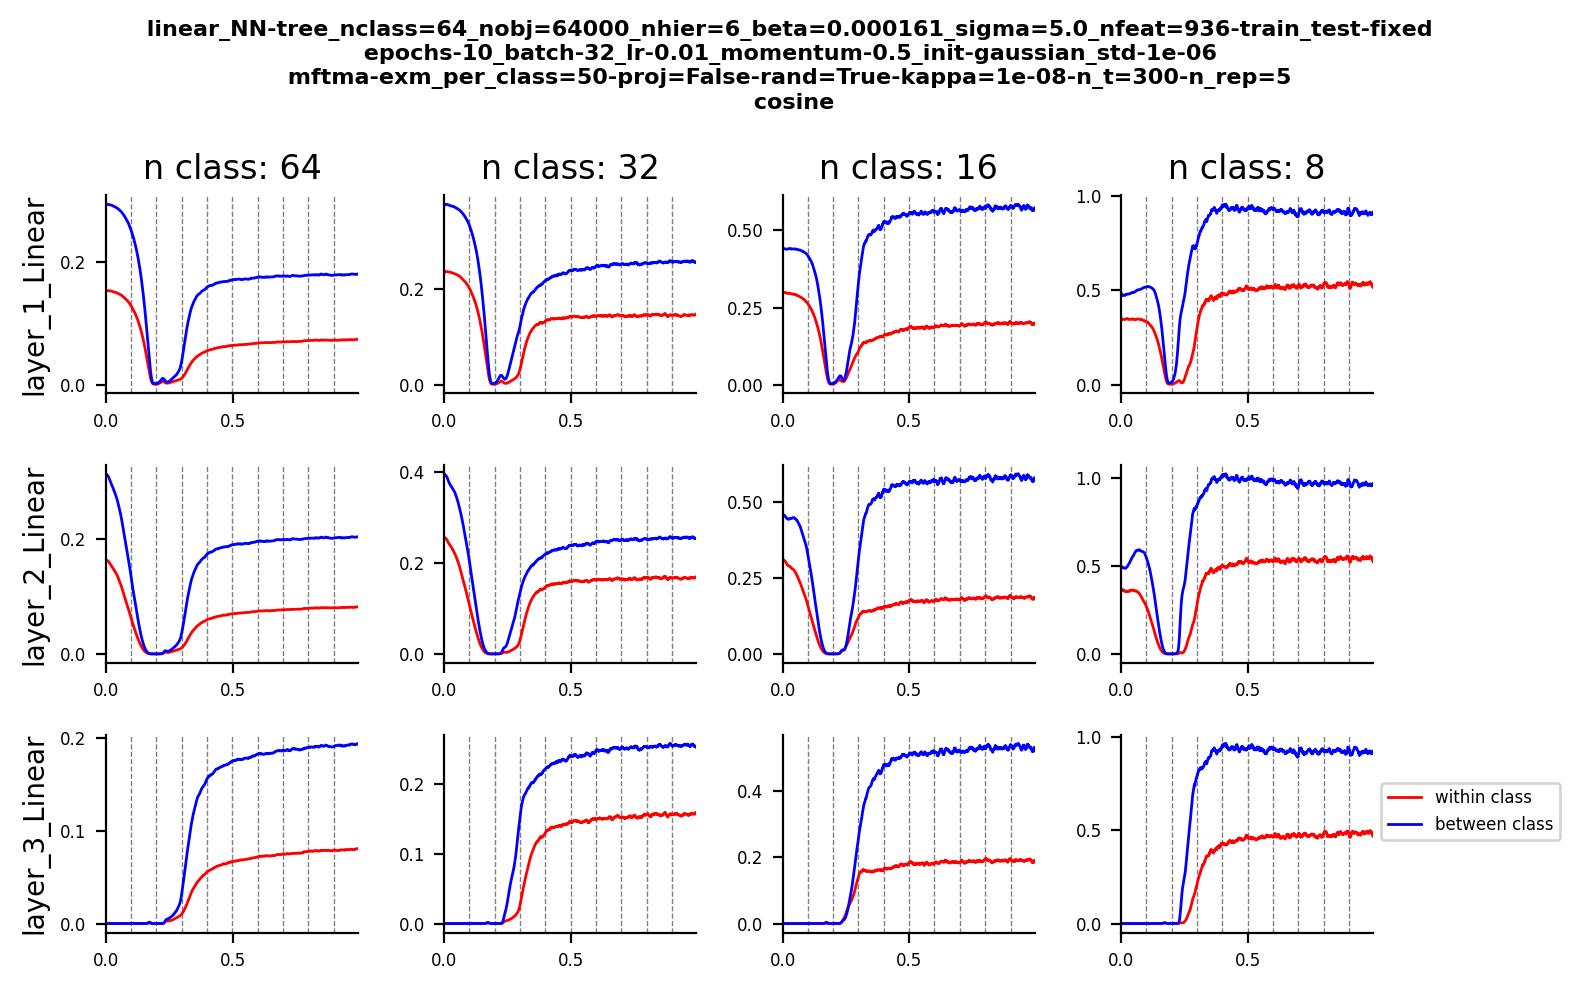

In [17]:

num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

av_window=10

fig, axes = plt.subplots(3, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
layer='layer_1_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[0]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][1,:],av_window),color=(0,0,1),linewidth=1)
ax.set_ylabel(layer)
ax.set_title(f"n class: {hier_within_class[0].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[1]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][1,:],av_window),color=(0,0,1),linewidth=1)
ax.set_title(f"n class: {hier_within_class[1].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)





ax=axes[2]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][1,:],av_window),color=(0,0,1),linewidth=1)
ax.set_title(f"n class: {hier_within_class[2].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[3]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][1,:],av_window),color=(0,0,1),linewidth=1)
ax.set_title(f"n class: {hier_within_class[3].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



# 

# plot layer 1 results
layer='layer_2_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[4]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][1,:],av_window),color=(0,0,1),linewidth=1)
ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[5]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][1,:],av_window),color=(0,0,1),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)




ax=axes[6]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][1,:],av_window),color=(0,0,1),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[7]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][1,:],av_window),color=(0,0,1),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)





# plot layer 1 results
layer='layer_3_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[8]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][1,:],av_window),color=(0,0,1),linewidth=1)
ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[9]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][1,:],av_window),color=(0,0,1),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)




ax=axes[10]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][0,:],av_window),color=(1,0,0),linewidth=1)
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][1,:],av_window),color=(0,0,1),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[11]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][0,:],av_window),color=(1,0,0),linewidth=1,label='within class')
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][1,:],av_window),color=(0,0,1),linewidth=1,label='between class')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)
plt.suptitle(f" {model_identifier} \n {train_identifier} \n {analyze_identifier} \n {data_['distance_metric']}",fontsize=8, fontweight='bold')

plt.tight_layout()

In [ ]:

num_colors=accuracies.shape[1]+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

av_window=10

fig, axes = plt.subplots(3, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
layer='layer_1_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[0]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][0,:]-hier_within_between[0][1,:],av_window),color=(1,0,0),linewidth=1)

ax.set_ylabel(layer)
ax.set_title(f"n class: {hier_within_class[0].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[1]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][0,:]-hier_within_between[1][1,:],av_window),color=(1,0,0),linewidth=1)

ax.set_title(f"n class: {hier_within_class[1].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)





ax=axes[2]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][0,:]-hier_within_between[2][1,:],av_window),color=(1,0,0),linewidth=1)

ax.set_title(f"n class: {hier_within_class[2].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[3]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][0,:]-hier_within_between[3][1,:],av_window),color=(1,0,0),linewidth=1)

ax.set_title(f"n class: {hier_within_class[3].shape[0]}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



# 

# plot layer 1 results
layer='layer_2_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[4]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][0,:]-hier_within_between[0][1,:],av_window),color=(1,0,0),linewidth=1)

ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[5]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][0,:]-hier_within_between[1][1,:],av_window),color=(1,0,0),linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)




ax=axes[6]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][0,:]-hier_within_between[2][1,:],av_window),color=(1,0,0),linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[7]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][0,:]-hier_within_between[3][1,:],av_window),color=(1,0,0),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)





# plot layer 1 results
layer='layer_3_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[8]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[0][0,:]-hier_within_between[0][1,:],av_window),color=(1,0,0),linewidth=1)
ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

ax=axes[9]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[1][0,:]-hier_within_between[1][1,:],av_window),color=(1,0,0),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)




ax=axes[10]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[2][0,:]-hier_within_between[2][1,:],av_window),color=(1,0,0),linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)



ax=axes[11]
ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[3][0,:]-hier_within_between[3][1,:],av_window),color=(1,0,0),linewidth=1,label='within class')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)
plt.suptitle(f" {model_identifier} \n {train_identifier} \n {analyze_identifier} \n {data_['distance_metric']}",fontsize=8, fontweight='bold')

plt.tight_layout()

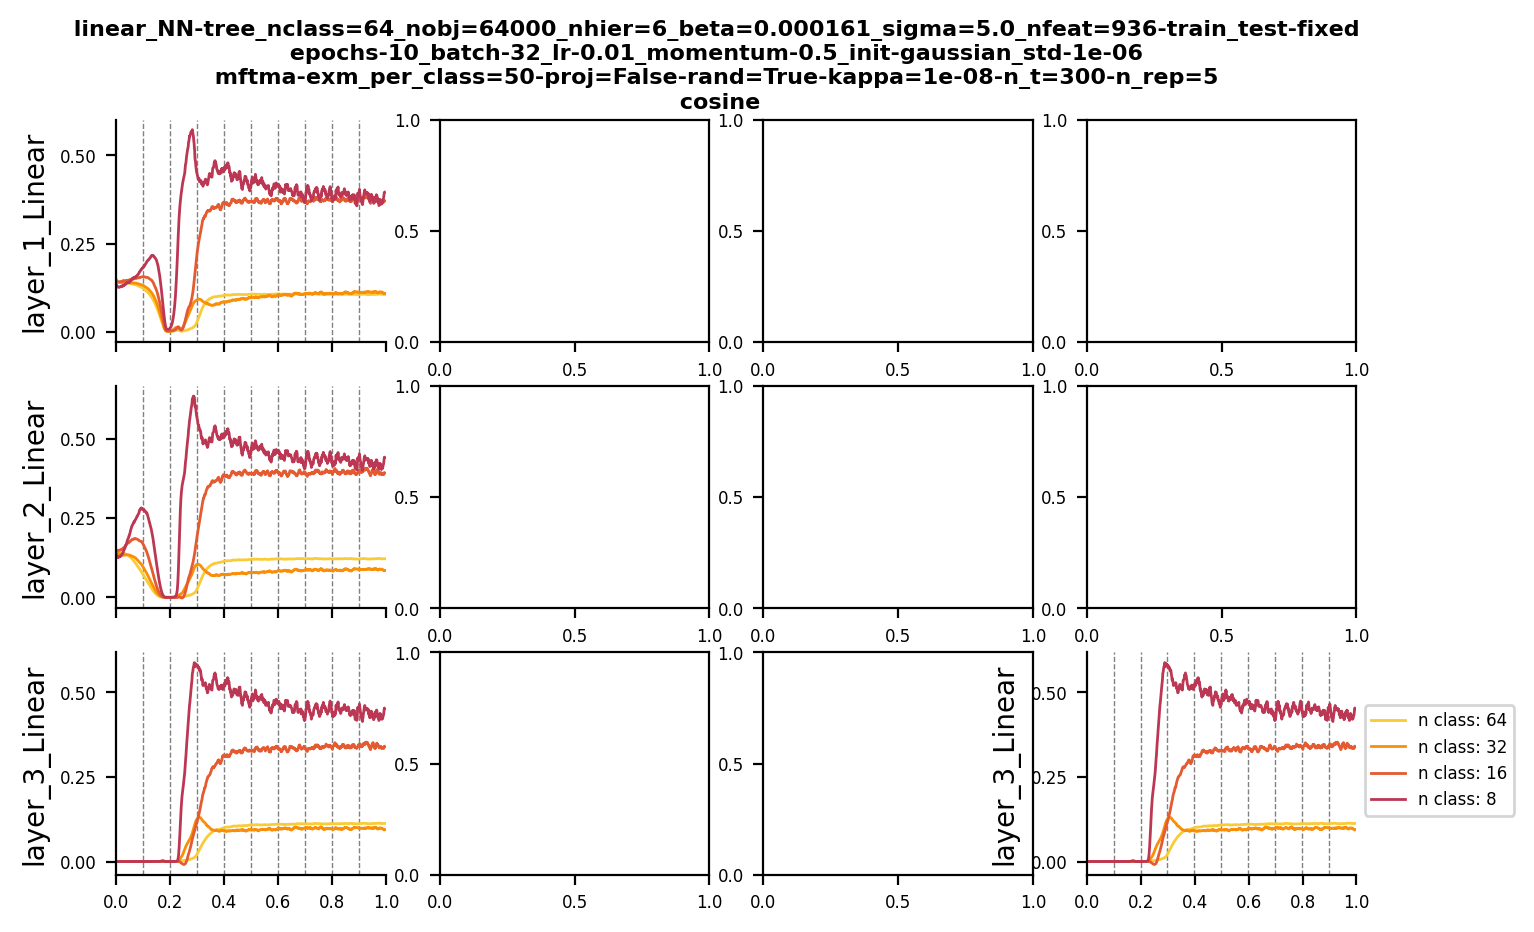

In [18]:
xmin=0
xmax=1
xtick=np.arange(0,12,2)/10
num_colors=accuracies.shape[1]+1
color_fact=num_colors+2
h0=cm.get_cmap('inferno',color_fact)
line_cols=np.flipud(h0(np.arange(color_fact)/color_fact))
line_cols=line_cols[1:,:]
av_window=10

fig, axes = plt.subplots(3, 4, figsize=(8, 5),dpi=200,frameon=False)

axes=axes.flatten()
[plt.setp(ax.get_xticklabels(), fontsize=6) for ax in axes]
[plt.setp(ax.get_yticklabels(), fontsize=6) for ax in axes]
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plot layer 1 results
layer='layer_1_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[0]

for t in range(len(hier_within_between)):
    ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[t][1,:]-hier_within_between[t][0,:],av_window),color=line_cols[t,:],linewidth=1,label=f"n class: {hier_within_class[t].shape[0]}")


ax.set_ylabel(layer)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.axes.xaxis.set_ticks(xtick)
ax.axes.xaxis.set_ticklabels([])



# 

# plot layer 1 results
layer='layer_2_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[4]
for t in range(len(hier_within_between)):
    ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[t][1,:]-hier_within_between[t][0,:],av_window),color=line_cols[t,:],linewidth=1,label=f"n class: {hier_within_class[t].shape[0]}")


ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.axes.xaxis.set_ticks(xtick)
ax.axes.xaxis.set_ticklabels([])






# plot layer 1 results
layer='layer_3_Linear'
hier_within_between=[]
for k_idx,_ in enumerate(hier_within_class):
    withins=[]
    betweens=[]
    for X in covar_res[layer]:
        within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
        between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
        withins.append(np.mean(within))
        betweens.append(np.mean(between))
    hier_within_between.append(np.stack([withins,betweens]))

    
ax=axes[8]

for t in range(len(hier_within_between)):
    ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[t][1,:]-hier_within_between[t][0,:],av_window),color=line_cols[t,:],linewidth=1,label=f"n class: {hier_within_class[t].shape[0]}")

ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.axes.xaxis.set_ticks(xtick)




ax=axes[11]

for t in range(len(hier_within_between)):
    ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[t][1,:]-hier_within_between[t][0,:],av_window),color=line_cols[t,:],linewidth=1,label=f"n class: {hier_within_class[t].shape[0]}")

ax.set_ylabel(layer)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.axes.xaxis.set_ticks(xtick)



ax.legend(bbox_to_anchor=(1, .5, 0.3, 0.3),fontsize=6)

plt.suptitle(f" {model_identifier} \n {train_identifier} \n {analyze_identifier} \n {data_['distance_metric']}",fontsize=8, fontweight='bold')

#plt.tight_layout()
fig.savefig(os.path.join(results_dir,model_identifier+'_center_covar_difference.pdf'),transparent=True)

# zooming in 